In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

In [2]:
df = pd.read_csv('Colonia.csv', sep=';', index_col='Cidade')

In [3]:
def visualization(coord, pheromones):
    G = nx.DiGraph()
    for x,y,z in zip(coord['X'],coord['Y'], coord.index):
        G.add_node(z, pos=(x,y))
    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                if i < j:
                    G.add_edge(i,j, weight=pheromones[i-1, j-1])

    pos = nx.get_node_attributes(G, 'pos')
    widths = nx.get_edge_attributes(G, 'weight')
    nodelist = G.nodes()

    plt.figure(figsize=(20,14))

    nx.draw_networkx_nodes(G,pos,
                           nodelist=nodelist,
                           node_size=500,
                           node_color='gold',
                           alpha=0.8)
    nx.draw_networkx_edges(G,pos,
                           edgelist = widths.keys(),
                           width=list(widths.values()),
                           edge_color='plum',
                           style='-',
                           connectionstyle="arc3,rad=0.1")
    # connectionstyle only works with directed graphs at present
    nx.draw_networkx_labels(G, pos=pos,
                            labels=dict(zip(nodelist,nodelist)),
                            font_color='midnightblue',
                            font_family='monospace',
                            font_size=15)
    plt.box(False)
    plt.show()

In [4]:
#pheromones = np.ones((len(df),len(df)))
#visualization(df, pheromones)

In [112]:
class AntColony:
    def __init__(self, ants, evaporation_rate=0.1, intensification=1, alpha=1, beta=1):
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.intensification = intensification
        self.alpha = alpha
        self.beta = beta

    def _init(self):
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        self.heuristic_matrix = np.divide(1, self.map, out=np.zeros_like(self.map), where=self.map!=0)
        self.probability_matrix = self.pheromone_matrix**self.alpha * self.heuristic_matrix**self.beta
        self.available_nodes = list(range(num_nodes))
        self.pheromones = [np.copy(self.pheromone_matrix)]

    def _next_node(self, current_node):
        weights = self.probability_matrix[current_node, self.available_nodes]
        probabilities = weights / np.sum(weights)
        next_node = np.random.choice(self.available_nodes, p=probabilities)
        return next_node

    def _update_pheromones(self, paths):
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        for path in paths:
            i, j = path[:-1], path[1:]
            total_distance = np.sum(self.map[i, j])
            self.pheromone_matrix[i, j] += self.intensification/total_distance
            self.pheromone_matrix[j, i] += self.intensification/total_distance
    
    def _calculate_score(self, paths):
        scores = np.zeros(len(paths))
        for index, path in enumerate(paths):
            i,j = path[:-1], path[1:]
            scores[index] = np.sum(self.map[i,j])
        best = np.argmin(scores)
        return paths[best], scores[best]

    def find(self, distance_matrix, iterations=100, k_max=100, random=False):
        self.map = distance_matrix
        self._init()
        k = 0
        
        for it in range(iterations):
            paths = []
            path = []

            for ant in range(self.ants-len(paths)):
                current_node = ant
                if random:
                    current_node = self.available_nodes[np.random.randint(len(self.available_nodes))]
                while self.available_nodes:
                    path.append(current_node)
                    self.available_nodes.remove(current_node)
                    if self.available_nodes:
                        current_node = self._next_node(current_node)

                # go back to start
                path.append(path[0])
                paths.append(path)
                # reset path and available nodes
                path = []
                self.available_nodes = list(range(self.map.shape[0]))
            
            # scores and stop conditions
            best_path, best_score = self._calculate_score(paths)
            if it == 0:
                best_score_all = best_score
                self.best = best_score_all
                self.best_path = best_path
            else:
                if best_score < best_score_all:
                    best_score_all = best_score
                    self.best = best_score_all
                    self.best_path = best_path
            #paths = [self.best_path]
            
            # update pheromones on traveled edges and probabilities
            self._update_pheromones(paths)
            self.probability_matrix = self.pheromone_matrix**self.alpha * self.heuristic_matrix**self.beta
            self.pheromones.append(np.copy(self.pheromone_matrix))
            
            print(f'Best @ {it}: {round(best_score, 2)}; so far: {round(best_score_all, 2)}')
            
            if best_score == best_score_all:
                k += 1
            else:
                k = 0
            if k > k_max:
                print(f"{k_max} iterations with same path, stopping")
                break

In [118]:
# 'random' will initialize ants randomly on the graph
# can place more antes than available nodes this way
distances = distance_matrix(df.values, df.values)
colony = AntColony(ants=len(distances), evaporation_rate=.2, intensification=2, alpha=3, beta=2)
colony.find(distances, iterations=300, k_max=300, random=True)

Best @ 0: 94.24; so far: 94.24
Best @ 1: 94.96; so far: 94.24
Best @ 2: 84.11; so far: 84.11
Best @ 3: 81.33; so far: 81.33
Best @ 4: 65.54; so far: 65.54
Best @ 5: 67.11; so far: 65.54
Best @ 6: 62.74; so far: 62.74
Best @ 7: 60.05; so far: 60.05
Best @ 8: 61.3; so far: 60.05
Best @ 9: 59.73; so far: 59.73
Best @ 10: 59.73; so far: 59.73
Best @ 11: 59.73; so far: 59.73
Best @ 12: 58.97; so far: 58.97
Best @ 13: 58.97; so far: 58.97
Best @ 14: 58.97; so far: 58.97
Best @ 15: 59.73; so far: 58.97
Best @ 16: 58.97; so far: 58.97
Best @ 17: 58.97; so far: 58.97
Best @ 18: 59.73; so far: 58.97
Best @ 19: 59.73; so far: 58.97
Best @ 20: 58.97; so far: 58.97
Best @ 21: 58.97; so far: 58.97
Best @ 22: 58.97; so far: 58.97
Best @ 23: 58.97; so far: 58.97
Best @ 24: 59.73; so far: 58.97
Best @ 25: 58.97; so far: 58.97
Best @ 26: 59.55; so far: 58.97
Best @ 27: 58.97; so far: 58.97
Best @ 28: 58.97; so far: 58.97
Best @ 29: 58.97; so far: 58.97
Best @ 30: 59.73; so far: 58.97
Best @ 31: 58.97; s

Best @ 253: 58.97; so far: 58.97
Best @ 254: 59.73; so far: 58.97
Best @ 255: 58.97; so far: 58.97
Best @ 256: 58.97; so far: 58.97
Best @ 257: 59.73; so far: 58.97
Best @ 258: 58.97; so far: 58.97
Best @ 259: 58.97; so far: 58.97
Best @ 260: 58.97; so far: 58.97
Best @ 261: 59.73; so far: 58.97
Best @ 262: 58.97; so far: 58.97
Best @ 263: 59.73; so far: 58.97
Best @ 264: 59.73; so far: 58.97
Best @ 265: 58.97; so far: 58.97
Best @ 266: 58.97; so far: 58.97
Best @ 267: 58.97; so far: 58.97
Best @ 268: 58.97; so far: 58.97
Best @ 269: 58.97; so far: 58.97
Best @ 270: 58.97; so far: 58.97
Best @ 271: 58.97; so far: 58.97
Best @ 272: 59.73; so far: 58.97
Best @ 273: 58.97; so far: 58.97
Best @ 274: 58.97; so far: 58.97
Best @ 275: 60.38; so far: 58.97
Best @ 276: 59.73; so far: 58.97
Best @ 277: 58.97; so far: 58.97
Best @ 278: 58.97; so far: 58.97
Best @ 279: 59.73; so far: 58.97
Best @ 280: 58.97; so far: 58.97
Best @ 281: 59.73; so far: 58.97
Best @ 282: 58.97; so far: 58.97
Best @ 283

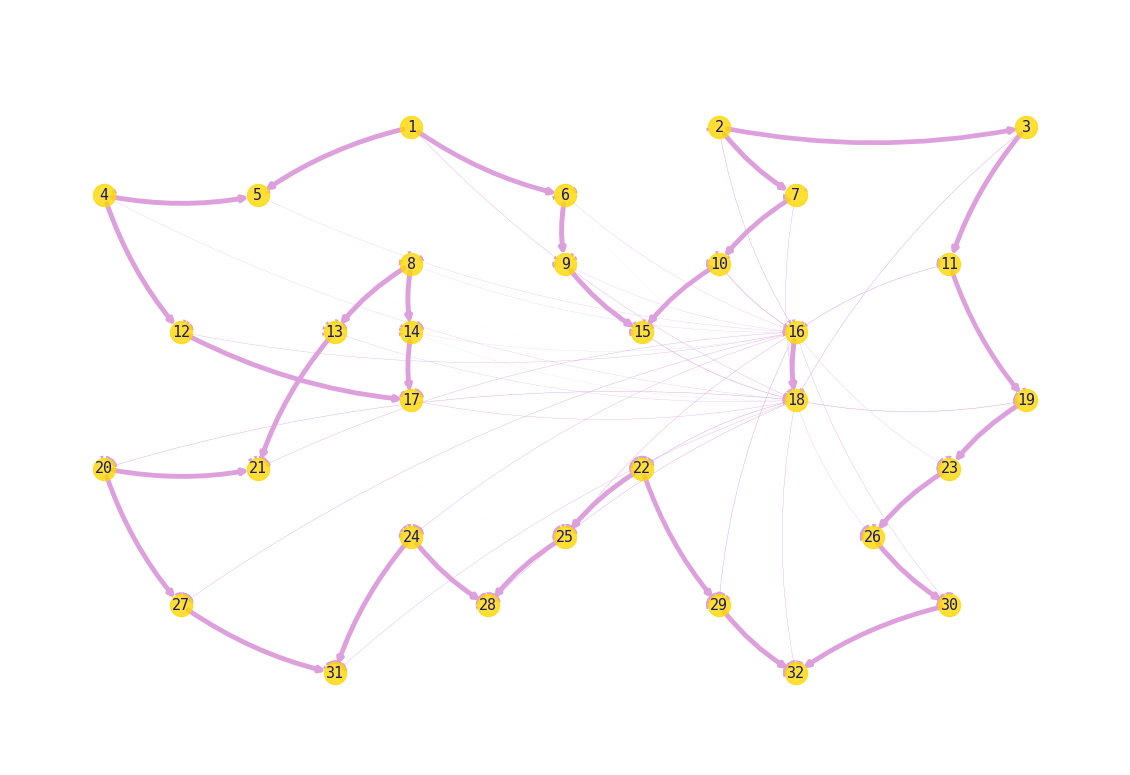

In [119]:
visualization(df, colony.pheromone_matrix)

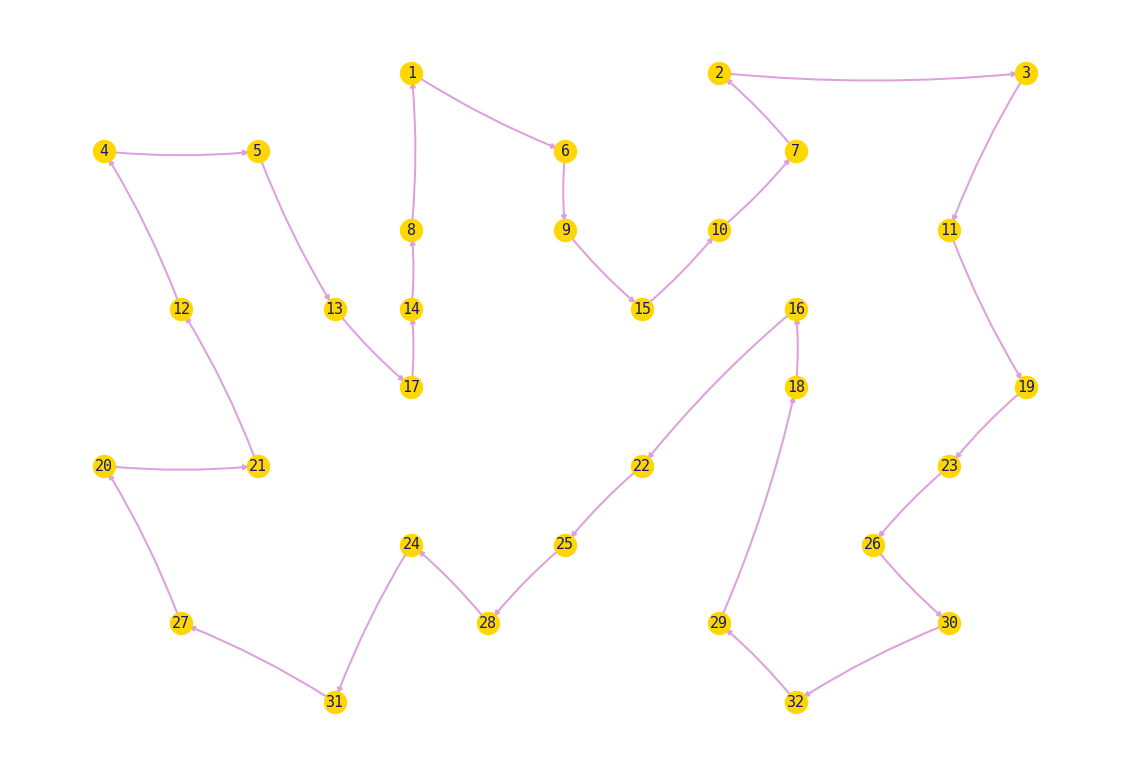

In [10]:
G = nx.DiGraph()
for x,y, z in zip(df['X'],df['Y'],df.index):
    G.add_node(z, pos=(x,y))
cities = []
cities = colony.best_path
for i,j in zip(cities[0:-1], cities[1:]):
    G.add_edge(i+1,j+1, weight=2)

pos = nx.get_node_attributes(G, 'pos')
widths = nx.get_edge_attributes(G, 'weight')
nodelist = G.nodes()

plt.figure(figsize=(20,14))
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=500,
                       node_color='gold')
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       connectionstyle="arc3,rad=0.05",
                       edge_color='plum')
nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='midnightblue',
                        font_family='monospace',
                        font_size=15,
                        verticalalignment='center')
plt.box(False)
plt.show()

In [21]:
for it in range(len(colony.pheromones)):
    G = nx.DiGraph()
    for x,y,z in zip(df['X'],df['Y'], df.index):
        G.add_node(z, pos=(x,y))
    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                if i < j:
                    G.add_edge(i,j, weight=colony.pheromones[it][i-1, j-1])

    pos = nx.get_node_attributes(G, 'pos')
    widths = nx.get_edge_attributes(G, 'weight')
    nodelist = G.nodes()

    plt.figure(figsize=(20,14))

    nx.draw_networkx_nodes(G,pos,
                           nodelist=nodelist,
                           node_size=500,
                           node_color='gold',
                           alpha=0.8)
    nx.draw_networkx_edges(G,pos,
                           edgelist = widths.keys(),
                           width=list(widths.values()),
                           edge_color='plum',
                           style='-',
                           connectionstyle="arc3,rad=0.1")
    nx.draw_networkx_labels(G, pos=pos,
                            labels=dict(zip(nodelist,nodelist)),
                            font_color='midnightblue',
                            font_family='monospace',
                            font_size=15)
    plt.box(False)
    
    plot_dir = f'apha{colony.alpha}beta{colony.beta}evaporation{colony.evaporation_rate}/'
    plot_file_name = f'{it}'

    if not os.path.isdir(plot_dir):
        os.makedirs(plot_dir)
    plt.savefig(plot_dir+plot_file_name)
    plt.close()